#Load Libraries

In [4]:
!pip install pyCompare

In [5]:
import pandas as pd
from glob import glob
import missingno as msno
import seaborn as sns
from pyCompare import blandAltman
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [6]:
#mount to google drive first
import io
from google.colab import drive  
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Load Data

In [7]:
#### change path if needed ####
#path = "raw_data/p*"
path = "/content/drive/My Drive/UNIVERSITY/Sem 4 - 2020/IFN - 646/Project/Data/p*"
filenames = sorted(glob(path))
dataframes = [pd.read_csv(f) for f in filenames]
#combine all files in the list
data = pd.concat(dataframes)
#export to csv
data.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

#Data Cleaning

In [8]:
data.head(20)
#weighted average of activity count
#for each 15 second window it goes through so classification is based on what is around these epochs

,timestamp,Actiwatch activity counts,Actiware classification,Apple Watch ENMO
0,01/01/2000 01:17:00,NaN,NaN,0.003123
1,01/01/2000 01:17:15,NaN,NaN,0.002960
2,01/01/2000 01:17:30,NaN,NaN,0.002921
3,01/01/2000 01:17:45,NaN,NaN,0.002907
4,01/01/2000 01:18:00,NaN,NaN,0.002932
5,01/01/2000 01:18:15,NaN,NaN,0.002989
6,01/01/2000 01:18:30,NaN,NaN,0.002895
7,01/01/2000 01:18:45,NaN,NaN,0.002916
8,01/01/2000 01:19:00,NaN,NaN,0.002746
9,01/01/2000 01:19:15,NaN,NaN,0.038737


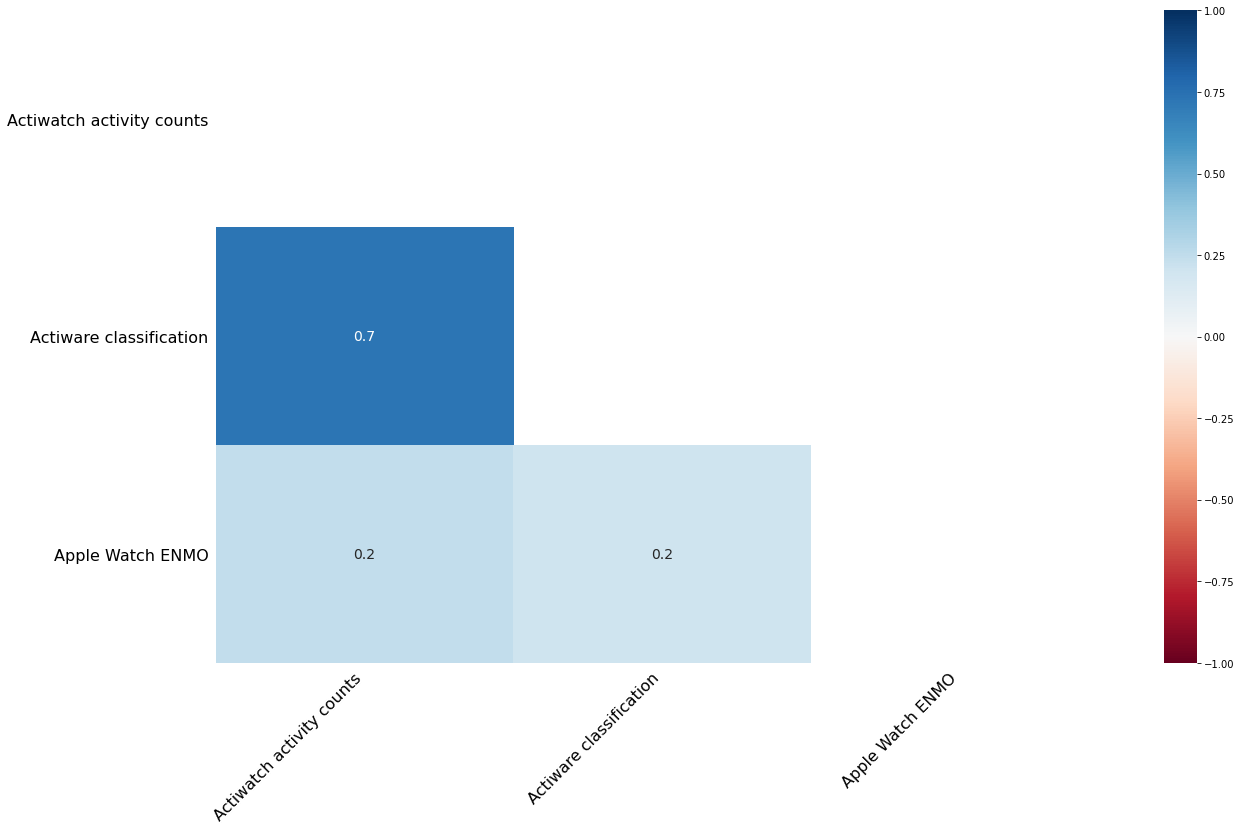

In [9]:
#need to deal with NAN's
msno.heatmap(data)

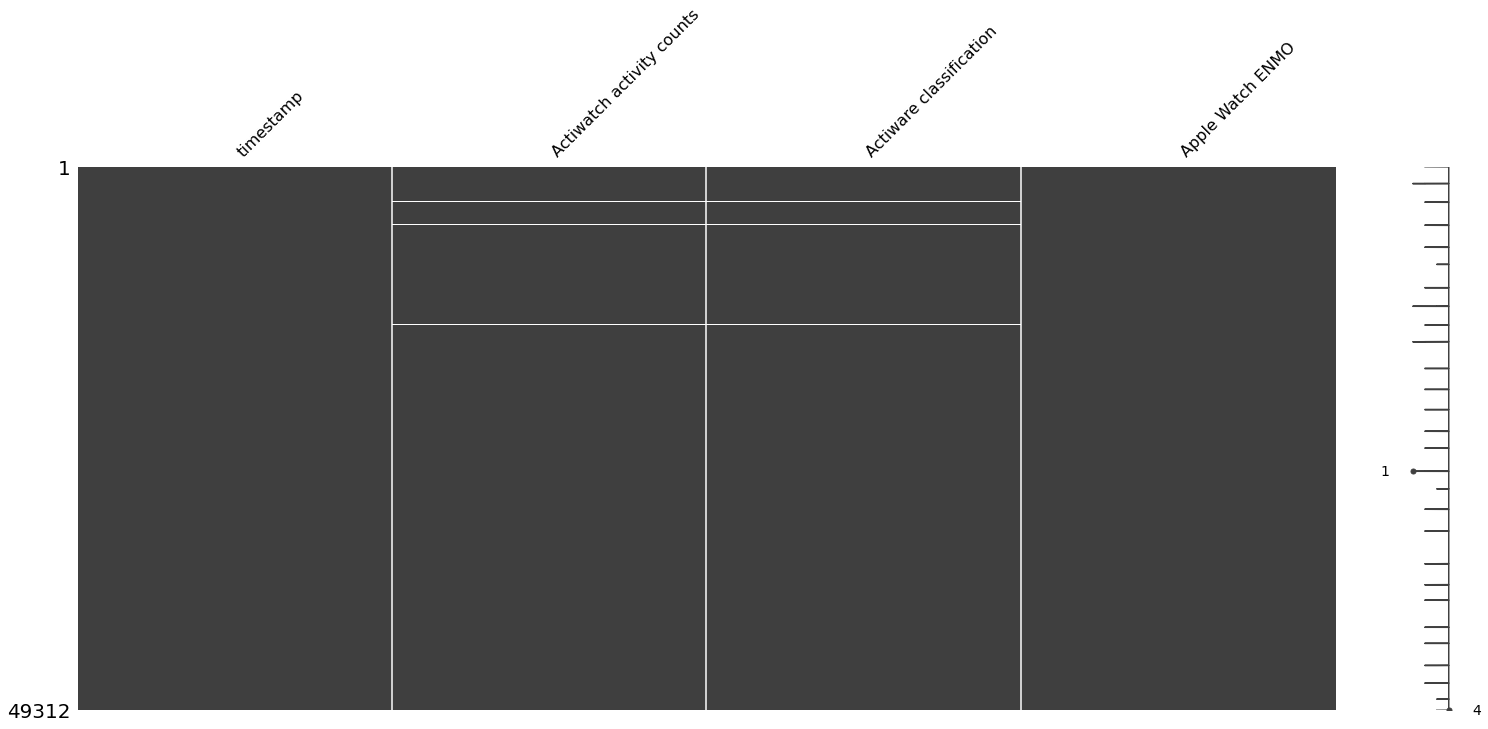

In [10]:
msno.matrix(data)

In [11]:
#

In [12]:
#drops all the nulls where both of the actiwatch data is missing
data = data.dropna(subset=["Actiwatch activity counts",	"Actiware classification"], how='all')

In [13]:
#need to figure out some way to map 1's and zero's based on the score of ENMO using the weighted average algo
#We will use the medium threshold of 40 as previous studies suggest his is more optimal

def weighted_avg_algo(x):
    return 1 if x>=40 else 0



#Data Exploration

In [14]:
###
#THIS NEEDS TO BE CHANGED AS ITS NOT HOW WE WANT TO DEAL WITH NULLS
###

data = data.dropna()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


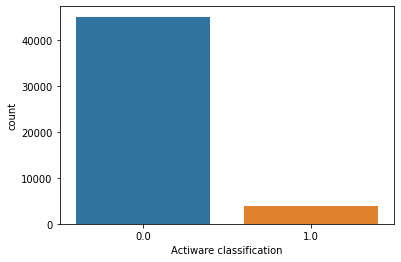

In [15]:
sns.countplot('Actiware classification', data= data)

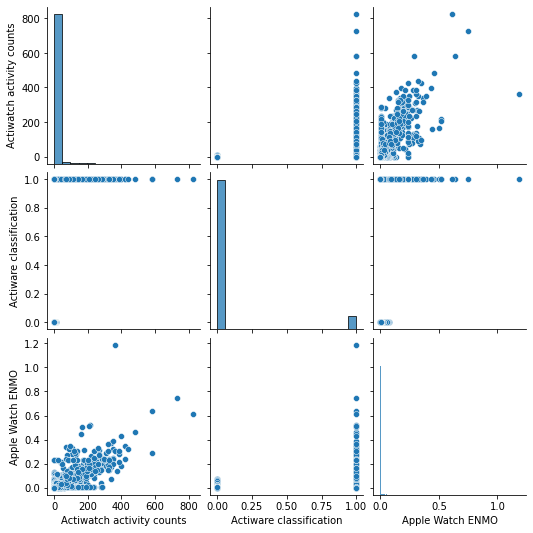

In [16]:
sns.pairplot(data)

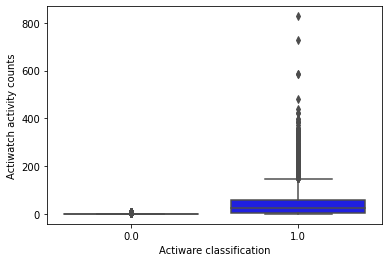

In [17]:
sns.boxplot(x=data["Actiware classification"], y = data["Actiwatch activity counts"], color = "blue")

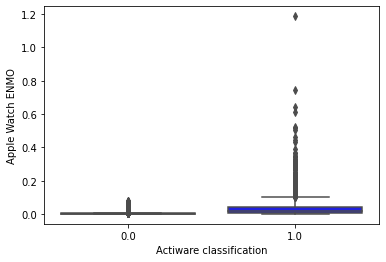

In [18]:
sns.boxplot(x=data["Actiware classification"], y = data["Apple Watch ENMO"], color = "blue")

# Transform ENMO to activity counts data

In [19]:
#transfor enmo to activity counts using linear regression

In [20]:
import statsmodels.api as sm
X = data["Apple Watch ENMO"]
X_con = sm.add_constant(X)
y = data["Actiwatch activity counts"]
model=sm.OLS(y,X_con)
result=model.fit()
print(result.summary2())

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                       Results: Ordinary least squares
Model:              OLS                       Adj. R-squared:     0.684      
Dependent Variable: Actiwatch activity counts AIC:                385023.3284
Date:               2020-10-13 02:22          BIC:                385040.9238
No. Observations:   48909                     Log-Likelihood:     -1.9251e+05
Df Model:           1                         F-statistic:        1.058e+05  
Df Residuals:       48907                     Prob (F-statistic): 0.00       
R-squared:          0.684                     Scale:              153.60     
------------------------------------------------------------------------------
                       Coef.    Std.Err.     t      P>|t|    [0.025    0.975] 
------------------------------------------------------------------------------
const                  -2.1918    0.0589  -37.2337  0.0000   -2.3072   -2.0764
Apple Watch ENMO      970.8765    2.9846  325.2957  0.0000  965.0266  976.7263
----

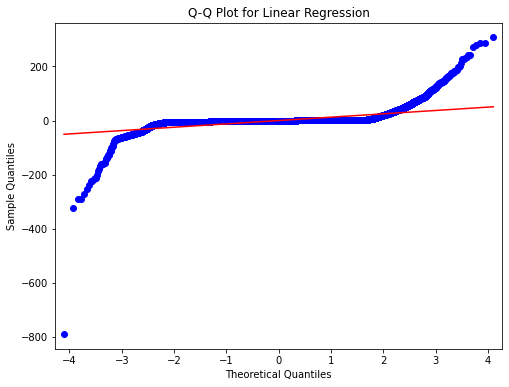

In [21]:
#QQ plot
fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(result.resid, ax=ax, line='s' )
plt.title('Q-Q Plot for Linear Regression')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


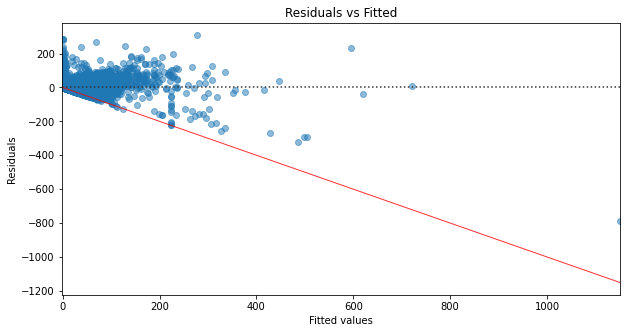

In [22]:
plot_lm_1 = plt.figure(figsize= (10,5))
plot_lm_1.axes[0] = sns.residplot(result.fittedvalues, y, data=data, 
                            lowess=True,
                            scatter_kws={'alpha': 0.5},
                            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

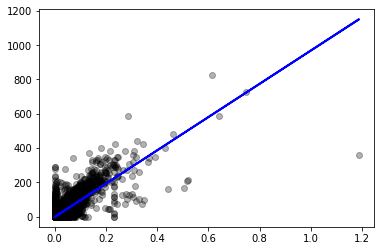

In [23]:
# Plot Regression
y_pred = result.predict()
plt.scatter(X, y,  color='black', alpha=0.3)
plt.plot(X, y_pred, color='blue', linewidth=2)

plt.show()

In [24]:
# Function to calculate the sum of the values in a specified range
def sumValues(start, end, constant, column):
    sum = 0
    for i in range(start, end):
        # Add ith ENMO activity count to the sum
        sum = sum + df.iloc[i, column]
    sum = constant * sum
    return sum

# Function to calculate the total activity counts
def getTotalActivityCount(column):
    # Empty list to store the values
    totalActivity = []
    
    for i in range(8, len(df)-8):
        # Calculate total activity count at the ith row using Phillips' algorithm
        value = sumValues(i - 8, i - 5, 0.04, column) + sumValues(i - 4, i - 1, 0.2, column) + 4*df.iloc[i, column] + sumValues(i + 1, i + 4, 0.2, column) + sumValues(i + 5, i + 8, 0.04, column)
        totalActivity.append(value)
        
    for i in range(0, 8):
        # Add nan value at the beginning of the list
        totalActivity.insert(i, np.nan)
        # Add nan value at the end of the list
        totalActivity.append(np.nan)
        
    return totalActivity 

# Function to classify if awake or asleep
def classification(row, threshold):
    try:
        count = int(row['Total activity count'])
        if count > threshold:
            return 1 # awake
        else:
            return 0 # asleep
    except ValueError:
        return np.nan

In [25]:
# Finds the index where the first 5 minutes of uninterrupted sleep occurs
def findStartSleep(ind):
    # Initialize parameter
    start = 0

    # Loop through list of index where activity count is less than threshold
    for i in range(0, len(ind)-1):

        # Check if next index is directly following the current index value
        if ind[i + 1] - ind[i] == 1:

            # Check if following two index values are sequential
            for k in range(2, 20):

                # If next index minus current index is not 1   
                if ind[i+k] - ind[i+k-1] != 1:
                    # Break out of inner for loop
                    break

                # If sequential, continue to next k value
                else:

                    # If all index values before k == 19 are sequential
                    if k == 19:
                        # Save ith index value as the starting position
                        start = ind[i]
                        # Break out of inner for loop
                        break

            # If the start parameter is not 0 (i.e. initial value)
            if start != 0:
                # Break out of for loop
                break
    return start

# Finds the index where the last 5 minutes of uniterrupted sleep occur
def findEndSleep(ind):
    # Initialize parameter
    end = 0

    # Loop through list of index where activity count is less than threshold
    for i in range(len(ind)-1, 0, -1):

        # Check if previous index is sequential with the current index value
        if ind[i] - ind[i - 1] == 1:

            # Check if following two index values are sequential
            for k in range(2, 20):

                # If next index minus current index is not 1   
                if ind[i - k + 1] - ind[i - k] != 1:
                    # Break out of inner for loop
                    break

                # If sequential, continue to next k value
                else:

                    # If all index values before k == 19 are sequential
                    if k == 19:
                        # Save ith index value as the starting position
                        end = ind[i]
                        # Break out of inner for loop
                        break

            # If the start parameter is not 0 (i.e. initial value)
            if end != 0:
                # Break out of for loop
                break
    return end

In [26]:
# Set the classification based on index values for uninterrupted sleep
def setClassification(start, end, df, column, threshold):
    classification = []
    # For all rows before the start value
    for i in range(0, start):
        # Set as awake
        classification.append(1)
    # For all rows from start to end value
    for i in range(start, end + 1):
        count = int(df.iloc[i, column])
        if count > threshold:
            classification.append(1) # awake
        else:
            classification.append(0) # asleep
    # For all rows from end to the length of the dataframe
    for i in range(end + 1, len(df)):
        # Set as awake
        classification.append(1)
    return classification

In [ ]:
# Create a list to store the predicted activity counts from the model
pred = result.predict()

data_t = [] 
k = 0 # counter
threshold = 40 

# Loop through all the files 
for f in filenames:
    # Read in file
    dataframe = pd.read_csv(f)
    
    # Drop rows with NaN
    df = dataframe.dropna()
    
    # Add in ENMO activity counts
    ## Create empty list to store predicted activity counts for current file
    ENMO_ac = []
    ## For the number of activity counts in the current file, append a predicted value to the list
    for count in df['Actiwatch activity counts']:
        ENMO_ac.append(pred[k])
        k = k + 1 
    
    # Create a new column using the predicted activity counts
    df['ENMO activity counts'] = ENMO_ac
       
    # Add in Actiwatch total activity counts
    df['Actiwatch total activity count'] = getTotalActivityCount(1)
    
    # Classify Actiwatch total activity count based on uniterrupted sleep 
    # Create a list to store the index of each epoch where total activity count is less than threshold
    ind = [i for i, v in enumerate(df['Actiwatch total activity count']) if v < threshold]
    start = findStartSleep(ind)
    end = findEndSleep(ind)
    df['Actiware classification1'] = setClassification(start, end, df, 5, threshold)
    
    # Calculate Total activity count
    df['Total activity count'] = getTotalActivityCount(4)
    
    # Classify Apple watch total activity count based on uniterrupted sleep 
    # Create a list to store the index of each epoch where total activity count is less than threshold
    ind = [i for i, v in enumerate(df['Total activity count']) if v < threshold]
    start = findStartSleep(ind)
    end = findEndSleep(ind)
    df['Classification'] = setClassification(start, end, df, 7, threshold)
    
    # Append to the list
    data_t.append(df)

# Join into a dataframe
data_t = pd.concat(data_t, axis=0, ignore_index=True)

# Save dataframe as csv
#data_t.to_csv('combined_classified.csv')

In [28]:
# Calculate accuracy score
accuracy_score(data_t['Actiware classification1'], data_t['Classification'])

0.9739516244453986

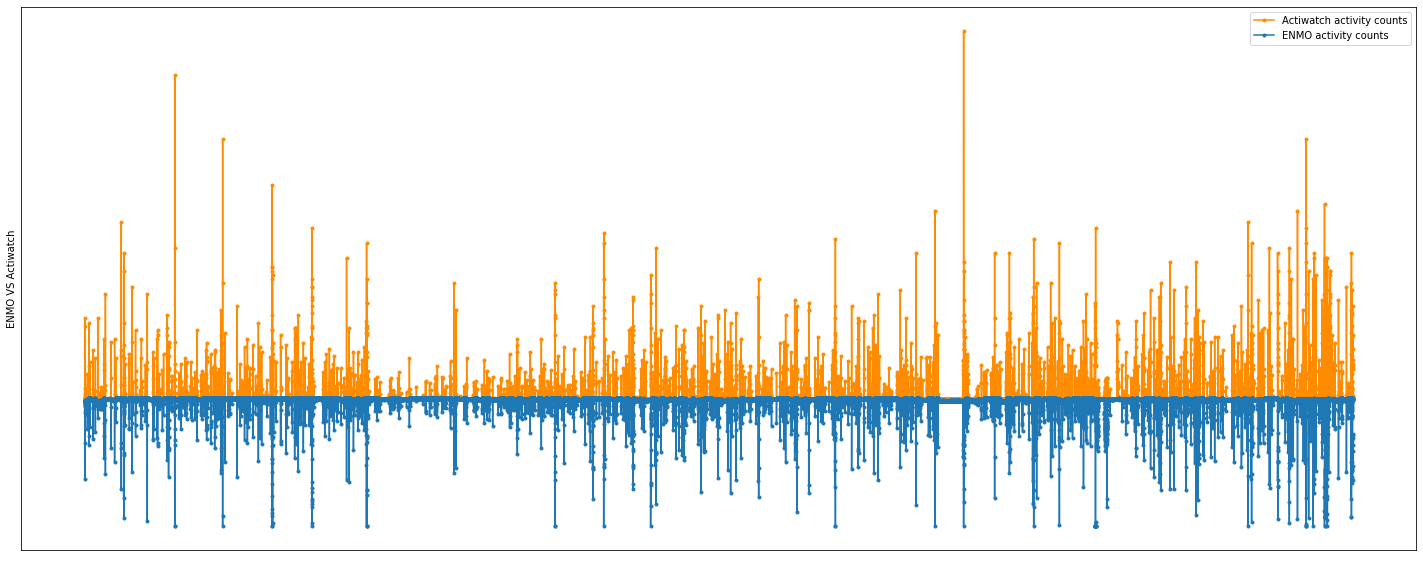

In [53]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(25)
ax.plot(data_t['Actiwatch activity counts'], linestyle = 'solid', marker = '.', color='darkorange',  label='Actiwatch activity counts')
ax.plot(data_t['ENMO activity counts']*-1, linestyle = 'solid', marker = '.', label='ENMO activity counts')
ax.set_yticks(())
ax.set_xticks(())
ax.set_ylabel("ENMO VS Actiwatch")
ax.legend()

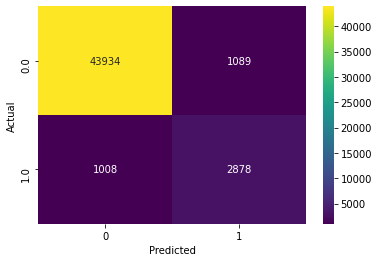

In [29]:
conf_matrix = pd.crosstab(data_t["Actiware classification"], data_t["Classification"], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(conf_matrix, annot=True,  cmap="viridis", fmt="d" )
plt.show()

In [32]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(data_t["Actiware classification"], data_t["Classification"]).ravel()

In [33]:
precision = tp/(tp + fp)
precision

0.7254852533400554

In [34]:
recall = tp/(tp+fn) 
recall

0.7406073082861554

In [35]:
true_neg = tn/(tn+fp)
true_neg

0.9758123625702418

In [37]:
#change enmo data skewing the regression
data.loc[data["Apple Watch ENMO"] > 0.25, 'Apple Watch ENMO'] = 0.25

In [38]:
import statsmodels.api as sm
X = data["Apple Watch ENMO"]
X_con = sm.add_constant(X)
y = data["Actiwatch activity counts"]
model=sm.OLS(y,X_con)
result=model.fit()
print(result.summary2())

                       Results: Ordinary least squares
Model:              OLS                       Adj. R-squared:     0.713      
Dependent Variable: Actiwatch activity counts AIC:                380257.7629
Date:               2020-10-13 02:26          BIC:                380275.3584
No. Observations:   48909                     Log-Likelihood:     -1.9013e+05
Df Model:           1                         F-statistic:        1.217e+05  
Df Residuals:       48907                     Prob (F-statistic): 0.00       
R-squared:          0.713                     Scale:              139.34     
------------------------------------------------------------------------------
                     Coef.    Std.Err.     t      P>|t|     [0.025     0.975] 
------------------------------------------------------------------------------
const                -3.1630    0.0569  -55.6314  0.0000    -3.2745    -3.0516
Apple Watch ENMO   1152.6308    3.3047  348.7867  0.0000  1146.1536  1159.1080
----

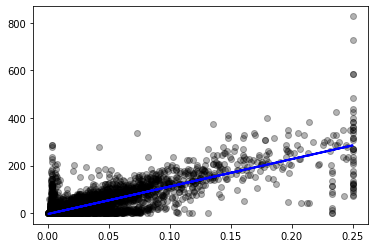

In [39]:
# Plot Regression
y_pred = result.predict()
plt.scatter(X, y,  color='black', alpha=0.3)
plt.plot(X, y_pred, color='blue', linewidth=2)

plt.show()

In [ ]:
# Create a list to store the predicted activity counts from the model
pred = result.predict()

data_t = [] 
k = 0 # counter
threshold = 40 

# Loop through all the files 
for f in filenames:
    # Read in file
    dataframe = pd.read_csv(f)
    
    # Drop rows with NaN
    df = dataframe.dropna()
    
    # Add in ENMO activity counts
    ## Create empty list to store predicted activity counts for current file
    ENMO_ac = []
    ## For the number of activity counts in the current file, append a predicted value to the list
    for count in df['Actiwatch activity counts']:
        ENMO_ac.append(pred[k])
        k = k + 1 
    
    # Create a new column using the predicted activity counts
    df['ENMO activity counts'] = ENMO_ac
       
    # Add in Actiwatch total activity counts
    df['Actiwatch total activity count'] = getTotalActivityCount(1)
    
    # Classify Actiwatch total activity count based on uniterrupted sleep 
    # Create a list to store the index of each epoch where total activity count is less than threshold
    ind = [i for i, v in enumerate(df['Actiwatch total activity count']) if v < threshold]
    start = findStartSleep(ind)
    end = findEndSleep(ind)
    df['Actiware classification1'] = setClassification(start, end, df, 5, threshold)
    
    # Calculate Total activity count
    df['Total activity count'] = getTotalActivityCount(4)
    
    # Classify Apple watch total activity count based on uniterrupted sleep 
    # Create a list to store the index of each epoch where total activity count is less than threshold
    ind = [i for i, v in enumerate(df['Total activity count']) if v < threshold]
    start = findStartSleep(ind)
    end = findEndSleep(ind)
    df['Classification'] = setClassification(start, end, df, 7, threshold)
    
    # Append to the list
    data_t.append(df)

# Join into a dataframe
data_t = pd.concat(data_t, axis=0, ignore_index=True)

# Save dataframe as csv
#data_t.to_csv('combined_classified.csv')

In [41]:
# Calculate accuracy score
accuracy_score(data_t['Actiware classification'], data_t['Classification'])

0.9529738902860414

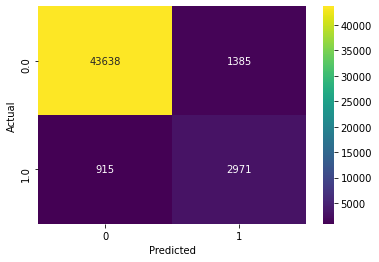

In [42]:
conf_matrix = pd.crosstab(data_t["Actiware classification"], data_t["Classification"], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(conf_matrix, annot=True,  cmap="viridis", fmt="d" )
plt.show()

In [44]:
tn, fp, fn, tp = confusion_matrix(data_t["Actiware classification"], data_t["Classification"]).ravel()

In [45]:
precision = tp/(tp + fp)
precision

0.6820477502295684

In [46]:
recall = tp/(tp+fn) 
recall

0.7645393721049922

In [47]:
true_neg = tn/(tn+fp)
true_neg

0.9692379450503076

It helps model accuraccy but doesnt alter the actual classifiaction accuracy all that much